In [57]:
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import eigh
import pandas as pd
from itertools import product
import math
from scipy.linalg import eigh

In [3]:
dev1 = qml.device("default.qubit", wires=2)

@qml.qnode(dev1)
def test():
    qml.Hadamard(0)
    qml.Hadamard(1)
    return qml.state()

state = test()

# Project onto |0> for the first qubit
projected = np.array([state[0], state[1]])
print(projected)

# Renormalize
norm = np.linalg.norm(projected)
post_selected_state = projected / norm
print(post_selected_state)

[0.5+0.j 0.5+0.j]
[0.70710678+0.j 0.70710678+0.j]


In [4]:
# as a method
def select_indices(n_qubits, measured_wire, outcome):
    return [
        i for i in range(2 ** n_qubits)
        if format(i, f'0{n_qubits}b')[measured_wire] == str(outcome)
    ]

indices = select_indices(n_qubits=2, measured_wire=0, outcome=0)
projected = np.array([state[i] for i in indices])
np.real(projected)
post_selected = projected / np.linalg.norm(projected)
post_selected

array([0.70710678+0.j, 0.70710678+0.j])

In [5]:
def select_indices_multi(n_qubits, measured_wires, outcomes):
    return [
        i for i in range(2 ** n_qubits)
        if all(format(i, f'0{n_qubits}b')[wire] == str(outcome) 
               for wire, outcome in zip(measured_wires, outcomes))
    ]
indices = select_indices_multi(n_qubits=2, measured_wires=[0], outcomes=[0])
projected = np.array([state[i] for i in indices])
post_selected = projected / np.linalg.norm(projected)
post_selected

array([0.70710678+0.j, 0.70710678+0.j])

In [166]:
a = 0.25
b = 0.75

# matrix to be decomposed
A = np.array(
    [[a,  0, 0,  b],
     [0, -a, b,  0],
     [0,  b, a,  0],
     [b,  0, 0, -a]]
)

LCU = qml.pauli_decompose(A)
LCU_coeffs, LCU_ops = LCU.terms()

print(f"LCU decomposition:\n {LCU}")
print(f"Coefficients:\n {LCU_coeffs}")
print(f"Unitaries:\n {LCU_ops}")

LCU decomposition:
 0.25 * (I(0) @ Z(1)) + 0.75 * (X(0) @ X(1))
Coefficients:
 [0.25 0.75]
Unitaries:
 [I(0) @ Z(1), X(0) @ X(1)]


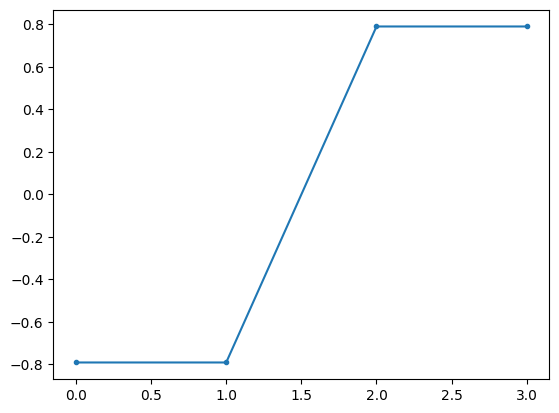

[-0.79056942 -0.79056942  0.79056942  0.79056942]
[[ 0.58471028  0.          0.81124219  0.        ]
 [ 0.         -0.81124219  0.          0.58471028]
 [ 0.          0.58471028  0.          0.81124219]
 [-0.81124219  0.          0.58471028  0.        ]]


In [171]:
val, vec = eigh(A)
plt.plot(val,'.-')
plt.show()
print(val)
print(vec)

In [37]:
dev1 = qml.device("default.qubit", wires=1)

# normalized square roots of coefficients
alphas = (np.sqrt(LCU_coeffs) / np.linalg.norm(np.sqrt(LCU_coeffs)))


@qml.qnode(dev1)
def prep_circuit():
    qml.StatePrep(alphas, wires=0)
    return qml.state()


print("Target state: ", alphas)
print("Output state: ", np.real(prep_circuit()))

Target state:  [0.5       0.8660254]
Output state:  [0.5       0.8660254]


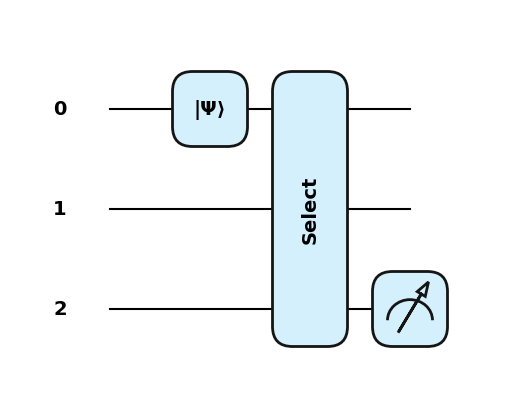

Expectation value for input |0>: 1.0
Expectation value for input |1>: -1.0


In [39]:
dev2 = qml.device("default.qubit", wires=3)

# unitaries
ops = LCU_ops
# relabeling wires: 0 → 1, and 1 → 2
unitaries = [qml.map_wires(op, {0: 1, 1: 2}) for op in ops]


@qml.qnode(dev2)
def sel_circuit(qubit_value):
    qml.BasisState(qubit_value, wires=0)
    qml.Select(unitaries, control=0)
    return qml.expval(qml.PauliZ(2))

qml.draw_mpl(sel_circuit, style='pennylane')([0])
plt.show()

print('Expectation value for input |0>:', sel_circuit([0]))
print('Expectation value for input |1>:', sel_circuit([1]))

In [12]:
@qml.qnode(dev2)
def lcu_circuit():  # block_encode
    # PREP
    qml.StatePrep(alphas, wires=0)

    # SEL
    qml.Select(unitaries, control=0)

    # PREP_dagger
    qml.adjoint(qml.StatePrep(alphas, wires=0))
    return qml.state()


output_matrix = qml.matrix(lcu_circuit)()
print("A:\n", A, "\n")
print("Block-encoded A:\n")
print(np.real(np.round(output_matrix,2)))

A:
 [[ 0.25  0.    0.    0.75]
 [ 0.   -0.25  0.75  0.  ]
 [ 0.    0.75  0.25  0.  ]
 [ 0.75  0.    0.   -0.25]] 

Block-encoded A:

[[ 0.25  0.    0.    0.75 -0.43  0.    0.    0.43]
 [ 0.   -0.25  0.75  0.    0.    0.43  0.43  0.  ]
 [ 0.    0.75  0.25  0.    0.    0.43 -0.43  0.  ]
 [ 0.75  0.    0.   -0.25  0.43  0.    0.    0.43]
 [-0.43  0.    0.    0.43  0.75  0.    0.    0.25]
 [ 0.    0.43  0.43  0.    0.   -0.75  0.25  0.  ]
 [ 0.    0.43 -0.43  0.    0.    0.25  0.75  0.  ]
 [ 0.43  0.    0.    0.43  0.25  0.    0.   -0.75]]


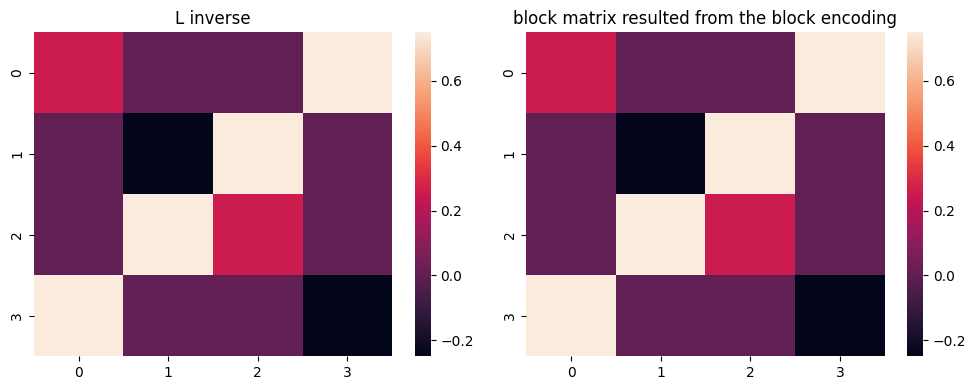

In [13]:
submatrix = output_matrix[:4, :4]

fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.heatmap(np.linalg.matrix_power(A, 1), ax=axes[0]) # vmin=0.01, vmax=0.05
axes[0].set_title("L inverse")
sns.heatmap(np.real(np.round(submatrix, 3)), ax=axes[1])
axes[1].set_title("block matrix resulted from the block encoding")
plt.tight_layout()
plt.show()

In [14]:
# measure the first qubit at |0>
state = lcu_circuit()
indices = select_indices(n_qubits=3, measured_wire=0, outcome=0)
projected = np.array([state[i] for i in indices])
print(np.real(projected))

[0.25 0.   0.   0.75]


1.3660254037844388


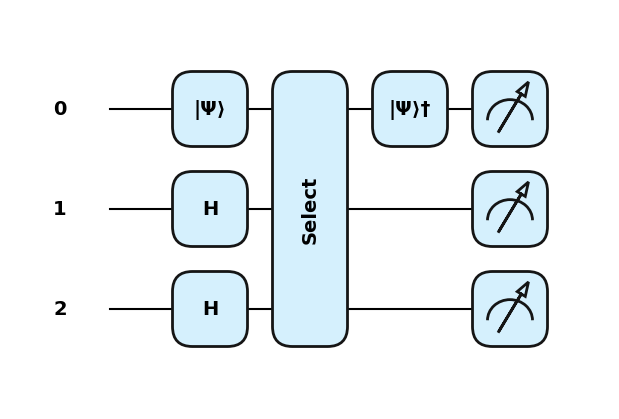

A:
 [[ 0.25  0.    0.    0.75]
 [ 0.   -0.25  0.75  0.  ]
 [ 0.    0.75  0.25  0.  ]
 [ 0.75  0.    0.   -0.25]] 

Block-encoded A:

[[ 0.5  -0.25 -0.25  0.5   0.   -0.43 -0.43  0.  ]
 [ 0.25  0.5  -0.5  -0.25  0.43  0.    0.   -0.43]
 [ 0.5  -0.25  0.25 -0.5   0.   -0.43  0.43  0.  ]
 [ 0.25  0.5   0.5   0.25  0.43  0.    0.    0.43]
 [-0.   -0.43 -0.43 -0.    0.5   0.25  0.25  0.5 ]
 [ 0.43 -0.    0.   -0.43 -0.25  0.5  -0.5   0.25]
 [-0.   -0.43  0.43  0.    0.5   0.25 -0.25 -0.5 ]
 [ 0.43 -0.   -0.    0.43 -0.25  0.5   0.5  -0.25]]
after projection :
 [0.5  0.25 0.5  0.25]
after normalization :
 [0.632 0.316 0.632 0.316]


In [15]:
scaling_factor = sum(abs(alphas))
print(scaling_factor)

@qml.qnode(dev2)
def lcu_circuit():  # block_encode
    qml.Hadamard(1)
    qml.Hadamard(2)
    
    qml.StatePrep(alphas, wires=0)
    qml.Select(unitaries, control=0)
    qml.adjoint(qml.StatePrep(alphas, wires=0))
    return qml.state()

qml.draw_mpl(lcu_circuit, style='pennylane')()
plt.show()

output_matrix = qml.matrix(lcu_circuit)()
print("A:\n", A, "\n")
print("Block-encoded A:\n")
print(np.real(np.round(output_matrix,2)))

state = lcu_circuit()
indices = select_indices(n_qubits=3, measured_wire=0, outcome=0)
projected = np.array([state[i] for i in indices])
print("after projection :\n",np.round(np.real(projected),3))
post_selected = projected / np.linalg.norm(projected)
print("after normalization :\n",np.round(np.real(post_selected),3))

In [282]:
def lcu(A):
    LCU = qml.pauli_decompose(A)
    coeff, op = LCU.terms()
    norm_factor = sum(abs(coeff))
    norm_coeff = (np.sqrt(coeff) / np.linalg.norm(np.sqrt(coeff)))
    return norm_coeff, op, norm_factor

def lcu_reduction(coeff, op, N): # extract N top terms
    idx = np.argsort(coeff)[-N:][::-1]
    coeff_red = [coeff[i] for i in idx]
    op_red = [op[i] for i in idx]
    norm_factor = sum(abs(op_red))
    norm_coeff_red = (np.sqrt(op_red) / np.linalg.norm(np.sqrt(op_red)))
    return norm_coeff_red, op_red, norm_factor

def init_config(A, coeff_red, op_red, norm_factor):
    n_control = int(math.log2(len(coeff_red)))
    n_target = int(math.log2(A.shape[0]))
    return n_control, n_target

def get_basis_state(n_qubits):
    return [list(state) for state in product([0, 1], repeat=n_qubits)]

iter_num = 0
input_coeff = 0
proj_norm_coeffs = []

def init_state(iter_num, input_coeff, n_target):
    if iter_num==0:
        for i in reg['target']:
            qml.Hadamard(i)
    else:
        base = get_basis_state(n_target)
        qml.Superposition(input_coeff, base, reg['target'], work_wire=reg['super_work'])

def block_encoding(coeff, op):
    qml.StatePrep(coeff, wires=reg['control'])
    qml.Select(op, control=reg['control'])
    qml.adjoint(qml.StatePrep(coeff, wires=reg['control']))

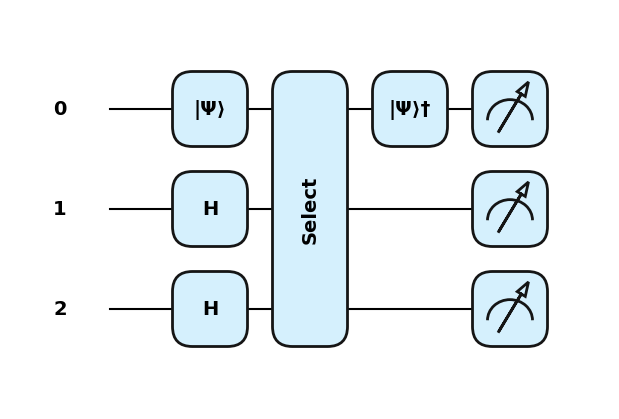

0.37499999999999967 [0.5      +0.j 0.       +0.j 0.25     +0.j 0.       +0.j 0.5      +0.j
 0.       +0.j 0.25     +0.j 0.       +0.j 0.       +0.j 0.       +0.j
 0.4330127+0.j 0.       +0.j 0.       +0.j 0.       +0.j 0.4330127+0.j
 0.       +0.j]


In [283]:
coeff, op, norm_factor = lcu(A)
n_control, n_target = init_config(A, coeff, op, norm_factor)
n_tot = wires=n_control+n_target+1

dev = qml.device("default.qubit", n_tot) 
reg = qml.registers({"control": n_control, "target": n_target, "super_work":1}) 
op = [qml.map_wires(op_elem, {i: i + n_control for i in range(n_target)}) for op_elem in op]

@qml.qnode(dev)
def power_circuit(A, iter_num, coeff, op, input_coeff, n_target):
    init_state(iter_num, input_coeff, n_target)
    block_encoding(coeff, op)
    return qml.expval(qml.Hermitian(A, wires=reg['target'])), qml.state()

qml.draw_mpl(power_circuit, style='pennylane')(A, iter_num, coeff, op, input_coeff, n_target)
plt.show()

val, vec = power_circuit(A, iter_num, coeff, op, input_coeff, n_target)
print(val, vec)

In [284]:
# post-processing
def zero_projector(n_qubits, measured_wires, outcomes):
    return [
        i for i in range(2 ** n_qubits)
        if all(format(i, f'0{n_qubits}b')[wire] == str(outcome) 
               for wire, outcome in zip(measured_wires, outcomes))]

def get_next_vec(vec, reg, iter_num):
    proj_idx = zero_projector(n_tot, measured_wires=reg.tolist(), outcomes=np.zeros(len(reg), dtype=int).tolist())
    proj = np.array([vec[i] for i in proj_idx]) # project onto |0> in the control qubit
    proj = proj[0::2] # effectively remove the auxiliary qubit
    proj_norm_coeff = np.linalg.norm(projected)
    proj_norm = projected / proj_norm_coeff
    iter_num +=1
    return proj_norm_coeff, np.real(proj), np.real(proj_norm), iter_num

proj_norm_coeff, proj, proj_norm, iter_num = get_next_vec(vec, reg['control'], iter_num)
# proj_norm_coeffs.append(proj_norm_coeff)
print(val, proj, iter_num)

0.37499999999999967 [0.5  0.25 0.5  0.25] 1


In [285]:
val, vec = power_circuit(A, iter_num, coeff, op, proj_norm, n_target)
proj_norm_coeff, proj, proj_norm, iter_num = get_next_vec(vec, reg['control'], iter_num)
proj_norm_coeffs.append(proj_norm_coeff)
print(val, proj, iter_num)

0.2249999999999998 [0.39528471 0.39528471 0.39528471 0.39528471] 2


In [286]:
print(proj_norm_coeffs)
np.prod(proj_norm_coeffs) * proj

[0.7905694150420945]


array([0.3125, 0.3125, 0.3125, 0.3125])

In [287]:
val, vec = power_circuit(A, iter_num, coeff, op, proj_norm, n_target)
proj_norm_coeff, proj, proj_norm, iter_num = get_next_vec(vec, reg['control'], iter_num)
proj_norm_coeffs.append(proj_norm_coeff)
print(val, proj, iter_num)
np.prod(proj_norm_coeffs) * proj

0.2249999999999998 [0.39528471 0.39528471 0.39528471 0.39528471] 3


array([0.24705294, 0.24705294, 0.24705294, 0.24705294])

In [288]:
val, vec = power_circuit(A, iter_num, coeff, op, proj_norm, n_target)
proj_norm_coeff, proj, proj_norm, iter_num = get_next_vec(vec, reg['control'], iter_num)
proj_norm_coeffs.append(proj_norm_coeff)
print(val, proj, iter_num)
np.prod(proj_norm_coeffs) * proj

0.2249999999999998 [0.39528471 0.39528471 0.39528471 0.39528471] 4


array([0.1953125, 0.1953125, 0.1953125, 0.1953125])

In [289]:
val, vec = power_circuit(A, iter_num, coeff, op, proj_norm, n_target)
proj_norm_coeff, proj, proj_norm, iter_num = get_next_vec(vec, reg['control'], iter_num)
proj_norm_coeffs.append(proj_norm_coeff)
print(val, proj, iter_num)
np.prod(proj_norm_coeffs) * proj

0.2249999999999998 [0.39528471 0.39528471 0.39528471 0.39528471] 5


array([0.15440809, 0.15440809, 0.15440809, 0.15440809])

In [290]:
val, vec = power_circuit(A, iter_num, coeff, op, proj_norm, n_target)
proj_norm_coeff, proj, proj_norm, iter_num = get_next_vec(vec, reg['control'], iter_num)
proj_norm_coeffs.append(proj_norm_coeff)
print(val, proj, iter_num)
np.prod(proj_norm_coeffs) * proj

0.2249999999999998 [0.39528471 0.39528471 0.39528471 0.39528471] 6


array([0.12207031, 0.12207031, 0.12207031, 0.12207031])

In [18]:
num_iter = 4
scaling_factor = sum(abs(alphas))

@qml.qnode(dev2)
def lcu_circuit(num_iter):  # block_encode
    for _ in range(num_iter):
        qml.StatePrep(alphas, wires=0)
        qml.Select(unitaries, control=0)`a
        qml.adjoint(qml.StatePrep(alphas, wires=0))
    return qml.state()

for i in range(1,num_iter+1):
    print(f"power : {i}")
    output_matrix = qml.matrix(lcu_circuit)(i)
    print(f"A^{i}:\n", np.real(np.linalg.matrix_power(A,i)), "\n")
    print(np.real(np.round(output_matrix,3)))

    state = lcu_circuit(i)
    indices = select_indices(n_qubits=3, measured_wire=0, outcome=0)
    projected = np.array([state[i] for i in indices])
    print(np.round(np.real(projected),3))
    post_selected = projected / np.linalg.norm(projected)
    print(np.round(np.real(post_selected),3))
    print("=============================")

power : 1
A^1:
 [[ 0.25  0.    0.    0.75]
 [ 0.   -0.25  0.75  0.  ]
 [ 0.    0.75  0.25  0.  ]
 [ 0.75  0.    0.   -0.25]] 

[[ 0.25   0.     0.     0.75  -0.433  0.     0.     0.433]
 [ 0.    -0.25   0.75   0.     0.     0.433  0.433  0.   ]
 [ 0.     0.75   0.25   0.     0.     0.433 -0.433  0.   ]
 [ 0.75   0.     0.    -0.25   0.433  0.     0.     0.433]
 [-0.433  0.     0.     0.433  0.75   0.     0.     0.25 ]
 [ 0.     0.433  0.433  0.     0.    -0.75   0.25   0.   ]
 [ 0.     0.433 -0.433  0.     0.     0.25   0.75   0.   ]
 [ 0.433  0.     0.     0.433  0.25   0.     0.    -0.75 ]]
[0.25 0.   0.   0.75]
[0.316 0.    0.    0.949]
power : 2
A^2:
 [[0.625 0.    0.    0.   ]
 [0.    0.625 0.    0.   ]
 [0.    0.    0.625 0.   ]
 [0.    0.    0.    0.625]] 

[[ 1.  0.  0. -0. -0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0. -0. -0.  0.]
 [ 0. -0.  1.  0.  0.  0. -0.  0.]
 [ 0.  0.  0.  1. -0.  0.  0. -0.]
 [-0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0. -0. -0.  0.  0.  1. -0.  0.]
 [ 0.  0. -0.  

In [292]:
for i in range(10):
    print(np.real(np.linalg.matrix_power(A,i)) @ np.ones(4)/np.sqrt(4) )

print('eig_vec : ', vec[-1])

[0.5 0.5 0.5 0.5]
[0.5  0.25 0.5  0.25]
[0.3125 0.3125 0.3125 0.3125]
[0.3125  0.15625 0.3125  0.15625]
[0.1953125 0.1953125 0.1953125 0.1953125]
[0.1953125  0.09765625 0.1953125  0.09765625]
[0.12207031 0.12207031 0.12207031 0.12207031]
[0.12207031 0.06103516 0.12207031 0.06103516]
[0.07629395 0.07629395 0.07629395 0.07629395]
[0.07629395 0.03814697 0.07629395 0.03814697]
eig_vec :  0j


In [64]:
init_vec = np.ones(4)/np.sqrt(4)
print(init_vec)
print(A @ init_vector)

# # visualization of the vector with heatmap
# vector = A @ init_vector
# # matrix = vector.reshape(1, -1)  # row-wise
# matrix = vector.reshape(-1, 1)  # column-wise
# sns.heatmap(matrix, annot=True)
# plt.show()

[0.5 0.5 0.5 0.5]
[0.5  0.25 0.5  0.25]


In [65]:
init_vec_pd = np.pad(init_vec, (0,4), 'constant')
print(init_vec_pd)
print(np.real(output_matrix @ init_vec_pd)[:4])

# # visualization of the vector with heatmap
# vector = np.real(output_matrix @ init_vec_pd)[:4]
# # matrix = vector.reshape(1, -1)  # row-wise
# matrix = vector.reshape(-1, 1)  # column-wise
# sns.heatmap(matrix, annot=True)
# plt.show()

[0.5 0.5 0.5 0.5 0.  0.  0.  0. ]
[0.5  0.25 0.5  0.25]


In [ ]:
coeffs = np.array([1/2, 1/2])
alphas = np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs))

proj_unitaries = [qml.Identity(0), qml.PauliZ(0)]

def lcu_circuit():  # block_encode
    # PREP
    qml.StatePrep(alphas, wires="ancilla")

    # SEL
    qml.Select(proj_unitaries, control="ancilla")

    # PREP_dagger
    qml.adjoint(qml.StatePrep(alphas, wires="ancilla"))
    return qml.state()


output_matrix = qml.matrix(lcu_circuit, wire_order=["ancilla", 0])()
print("Block-encoded projector:\n")
print(np.real(np.round(output_matrix,2)))

In [79]:
import pennylane as qml
import numpy as np

dev = qml.device('default.qubit', wires=4)  # 2 main wires + 2 ancilla

@qml.qnode(dev)
def qubitized_circuit():
    # 1. Prepare state |G⟩
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)
    
    # 2. Select: Controlled unitaries based on ancilla
    # Replace with your custom unitary embedding of A
    qml.ctrl(qml.BlockEncode([[0.1, 0.2], [0.3, 0.4]], wires=[0,1]), control=2)
    qml.ctrl(qml.BlockEncode([[0.1, 0.2], [0.3, 0.4]], wires=[0,1]), control=3)
    
    # 3. Repeat or simulate higher powers
    # In full qubitization, you'd use quantum signal processing here

    return qml.state()

state = qubitized_circuit()
print(np.round(state, 4))

[ 0.5   +0.j  0.05  +0.j  0.05  +0.j  0.4972+0.j  0.    +0.j  0.15  +0.j
  0.15  +0.j  0.0138+0.j  0.    +0.j  0.4728+0.j  0.4728+0.j -0.    +0.j
  0.    +0.j -0.0381+0.j -0.0381+0.j  0.0505+0.j]


In [82]:
A = [[0.1,0.2],[0.3,0.4]]
dev = qml.device('default.qubit', wires=2)
@qml.qnode(dev)
def example_circuit():
    qml.BlockEncode(A, wires=range(2))
    qml.BlockEncode(A, wires=range(2))
    qml.BlockEncode(A, wires=range(2))
    return qml.state()

print(np.real(np.linalg.matrix_power(A,3)))
print(qml.matrix(example_circuit)()[:2,:2])

[[0.037 0.054]
 [0.081 0.118]]
[[0.09889922 0.09779845]
 [0.39669767 0.39559689]]


In [77]:
A = [[0.2, 0, 0.2],[-0.2, 0.2, 0]]
op = qml.BlockEncode(A, wires=range(3))
print(np.round(qml.matrix(op), 2))

[[ 0.2   0.    0.2   0.96  0.02  0.    0.    0.  ]
 [-0.2   0.2   0.    0.02  0.96  0.    0.    0.  ]
 [ 0.96  0.02 -0.02 -0.2   0.2   0.    0.    0.  ]
 [ 0.02  0.98  0.   -0.   -0.2   0.    0.    0.  ]
 [-0.02  0.    0.98 -0.2  -0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.  ]]


In [78]:
import pennylane as qml
from pennylane import numpy as np

# Classical verification
A = np.array([[1, 1], [0, 1]])
A3_classical = np.linalg.matrix_power(A, 3)
print("Classical A^3:\n", A3_classical)

# Quantum device with 3 wires: data wires + control
dev = qml.device("default.qubit", wires=3)

def block_encode_A(control):
    # Emulate a simple block encoding for A:
    # A = [[1, 1], [0, 1]]
    qml.ctrl(qml.CNOT, control=control)(wires=[0,1])
    qml.ctrl(qml.PauliX, control=control)(wires=0)
    qml.ctrl(qml.CNOT, control=control)(wires=[0,1])
    qml.ctrl(qml.PauliX, control=control)(wires=0)
    # This combination crudely simulates adding +1 from wire 0 to wire 1 if control is |1>

@qml.qnode(dev)
def quantum_circuit():
    # Prepare |1⟩ input state on wire 1 (right side of classical input vector)
    qml.PauliX(wires=1)
    # Activate control qubit
    qml.PauliX(wires=2)
    # Apply block encoding three times to simulate A^3
    block_encode_A(2)
    block_encode_A(2)
    block_encode_A(2)
    return qml.state()

# Run quantum simulation
state = quantum_circuit()
print("\nQuantum state after applying A^3 block encoding:")
print(np.round(state, 3))

Classical A^3:
 [[1 3]
 [0 1]]

Quantum state after applying A^3 block encoding:
[0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
